# Analyze modifications of the gamma rule on the entire MNIST MLP network

#### Loading stuff

In [2]:
%load_ext autoreload
%autoreload 2

device = "cpu"
MNIST_CNN_PATH = './models/mnist_cnn_v2.torch'
data_dir = "./dataset"
cat16_dir = data_dir + "/cat16"

import os
import torch
import copy
from tqdm import tqdm
from util.util_cnn import get_test_loader, CNN, test

from util.util_gamma_rule import global_conv_matrix, forw_surrogate_matrix,  \
                back_matrix, smart_gamma_func, \
                calc_evals, calc_evals_batch, \
                plot_evals_lineplot, \
                conv_matrix_from_pytorch_layer, \
                global_conv_matrix_from_pytorch_layer, \
                calc_gamma_for_sign_flip

from util.util_gamma_layers import GammaPerNeuronLayer, GammaWoSignFlipsLayer, Conv2dAsMatrixLayer

from util.util_data_summary import *

import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# vgg experiments
import cv2
import torchvision
from torchvision import transforms, datasets
from PIL import Image

# lrp-tutorial sub repo
from lrp_tutorial import utils as tut_utils

model = CNN().to(device)
model.load_state_dict(torch.load(MNIST_CNN_PATH))

test(model, device, get_test_loader())

/Users/johannes/Applications/miniconda3/envs/msc2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1024, 20, 4, 4])
torch.Size([1024, 320])
torch.Size([1024, 20, 4, 4])
torch.Size([1024, 320])
torch.Size([1024, 20, 4, 4])
torch.Size([1024, 320])
torch.Size([1024, 20, 4, 4])
torch.Size([1024, 320])
torch.Size([1024, 20, 4, 4])
torch.Size([1024, 320])
torch.Size([1024, 20, 4, 4])
torch.Size([1024, 320])
torch.Size([1024, 20, 4, 4])
torch.Size([1024, 320])
torch.Size([1024, 20, 4, 4])
torch.Size([1024, 320])
torch.Size([1024, 20, 4, 4])
torch.Size([1024, 320])
torch.Size([784, 20, 4, 4])
torch.Size([784, 320])

Test set: Average loss: 0.0510, Accuracy: 9833/10000 (98%)



In [3]:
# model.put_info_layers()

### Load data

In [3]:
test_loader = get_test_loader(False)

mini = +np.inf
maxi = -np.inf

for i, (data, target) in enumerate(test_loader):
    if data.min() < mini: mini = data.min()
    if data.max() > maxi: maxi = data.max()

lb, hb = mini, maxi

In [4]:
test_loader = get_test_loader(False)
for i, (data, target) in enumerate(test_loader):
    break

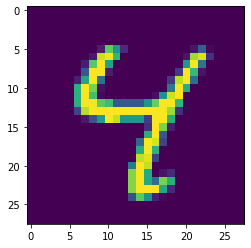

In [5]:
x = data[6]
plt.imshow(x[0])
plt.show()

### Load model and compute forward pass

In [20]:
layers = list(model._modules['features']) + ["reshape"] + tut_utils.toconv(list(model._modules['classifier']))
layers = [l for l in layers if not isinstance(l, torch.nn.Dropout1d)]
L = len(layers)

0 Linear(in_features=320, out_features=50, bias=True)
3 Linear(in_features=50, out_features=10, bias=True)


In [21]:
# A = [data]+[None]*L
A = [x[None]]+[None]*L

for l in range(L):
    if layers[l] == "reshape":
        A[l+1] = A[l].reshape((-1, 320, 1, 1))
    else:
        A[l+1] = layers[l].forward(A[l])

In [22]:
for i in range(L):
    l = layers[i]
    print(i, "Input:", list(A[i].shape), '->', str(l).split('(')[0],
    (list(l.weight.shape)) if isinstance(l, torch.nn.Conv2d) else "")
print(L, "Output:", list(A[L].shape))

0 Input: [1, 1, 28, 28] -> Conv2d [10, 1, 5, 5]
1 Input: [1, 10, 24, 24] -> MaxPool2d 
2 Input: [1, 10, 12, 12] -> ReLU 
3 Input: [1, 10, 12, 12] -> Conv2d [20, 10, 5, 5]
4 Input: [1, 20, 8, 8] -> Dropout2d 
5 Input: [1, 20, 8, 8] -> MaxPool2d 
6 Input: [1, 20, 4, 4] -> ReLU 
7 Input: [1, 20, 4, 4] -> reshape 
8 Input: [1, 320, 1, 1] -> Conv2d [50, 320, 1, 1]
9 Input: [1, 50, 1, 1] -> ReLU 
10 Input: [1, 50, 1, 1] -> Conv2d [10, 50, 1, 1]
11 Output: [1, 10, 1, 1]


In [71]:
layers_conv_as_mat = [None]*L
for l in range(L):
    if isinstance(layers[l], torch.nn.Conv2d):
        layers_conv_as_mat[l] = Conv2dAsMatrixLayer(layers[l], A[l][0].shape, A[l+1][0].shape)
        a = layers_conv_as_mat[l].forward(A[l])
        b = layers[l]            .forward(A[l])

        assert a.shape == b.shape, "Inequal shape"
        assert torch.allclose(a, b, atol=1e-5), f"Inequal result, max diff: {(a-b).abs().max()}"

In [115]:
modes = {
    0: "LRP-0", 
    1: "Gamma < 4",
    
    # 5: "LRP-composite", 

    # 11: "Gamma per Neuron >= 20", 
    12: "Gamma per Neuron < 4", 
    
    # 21: "Gamma wo Sign Flips >= 20", 
    # 22: "Gamma wo Sign Flips < 16",

    # 99: "info"

    101: "Gamma < 4 mat",
    112: "Gamma per Neuron < 4 mat",
}
relevancies_per_mode = {}

def rel(index):
    if type(index) is int:
        index = modes[index]
    assert type(index) is str
    return copy.deepcopy(relevancies_per_mode[index])

In [123]:
param_gamma = .8
param_gamma_scale = .99
res = []

for mode in tqdm(modes.values()):
    # if mode in relevancies_per_mode: continue

    R = [None]*L + [(A[-1]*(A[-1] == A[-1].max())).data]

    for l in range(1,L)[::-1]:
        
        A[l] = (A[l].data).requires_grad_(True)

        if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

        if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

            if isinstance(layers[l], torch.nn.AvgPool2d):
                helper_layer = tut_utils.newlayer(layers[l], rho)

            elif mode=='Gamma < 4' and l < 4:
                rho = lambda p: p + param_gamma*p.clamp(min=0);
                helper_layer = tut_utils.newlayer(layers[l], rho)

            elif mode=='Gamma per Neuron < 4' and l < 4:
                helper_layer = GammaPerNeuronLayer(layers[l], gamma_scale=param_gamma_scale)

            elif mode=='Gamma < 4 mat' and l < 4:
                helper_layer = copy.deepcopy(layers_conv_as_mat[l])
                helper_layer.set_gamma(param_gamma)

            elif mode=='Gamma per Neuron < 4 mat' and l < 4:
                helper_layer = copy.deepcopy(layers_conv_as_mat[l])
                helper_layer.set_gamma_per_neuron(param_gamma_scale)
                
            else:
                rho = lambda p: p;
                helper_layer = tut_utils.newlayer(layers[l], rho)

            incr = lambda z: z+1e-9
            z = incr(helper_layer.forward(A[l]))                            # step 1

            s = (R[l+1]/z).data                                             # step 2
            (z*s).sum().backward(); c = A[l].grad                           # step 3
            R[l] = (A[l]*c).data 

            if mode=='info':
                print(A[l].shape, '->', z.shape)
                print(A[l].flatten().shape, '->', z.flatten().shape)

        elif layers[l] == "reshape":
            R[l] = R[l+1].reshape(A[l].shape)
        else:
            R[l] = R[l+1]

        # if l == 3:
        #     # res.append((A[l]*c).data)
        #     res.append(z)


    ### layer 0 => zB rule -> My implementation sucks though ###

    # A[0] = (A[0].data).requires_grad_(True)
    # lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
    # hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

    # z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
    # z -= tut_utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
    # z -= tut_utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
    # s = (R[1]/z).data                                                      # step 2
    # (z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
    # R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4

    if mode=="info": continue
    relevancies_per_mode[mode] = copy.deepcopy(R)

100%|██████████| 5/5 [00:00<00:00, 14.01it/s]


shape: (20, 4, 4) - before layer reshape
mean absolute relevancy 0.09250301


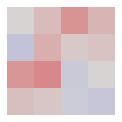

shape: (20, 8, 8) - before layer AvgPool2d(kernel_size=2, stride=2, padding=0)
mean absolute relevancy 0.053904705


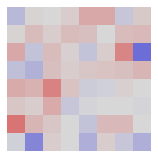

shape: (10, 12, 12) - before layer Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
mean absolute relevancy 12.410915


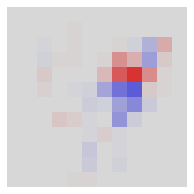

In [125]:
R = rel(12)

for i,l in enumerate([7, 5, 3]):
    dat = np.array(R[l][0])
    print("shape:", dat.shape, "- before layer", layers[l])
    print("mean absolute relevancy", np.abs(dat).mean())
    tut_utils.heatmap(dat.sum(axis=0), 0.5*i+1.5, 0.5*i+1.5)

shape: (20, 4, 4) - before layer reshape
mean absolute relevancy 0.09250301


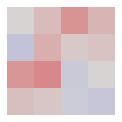

shape: (20, 8, 8) - before layer AvgPool2d(kernel_size=2, stride=2, padding=0)
mean absolute relevancy 0.053904705


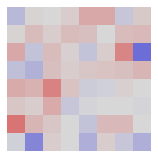

shape: (10, 12, 12) - before layer Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
mean absolute relevancy 0.17025058


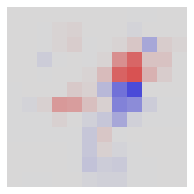

In [127]:
R = rel(112)

for i,l in enumerate([7, 5, 3]):
    dat = np.array(R[l][0])
    print("shape:", dat.shape, "- before layer", layers[l])
    print("mean absolute relevancy", np.abs(dat).mean())
    tut_utils.heatmap(dat.sum(axis=0), 0.5*i+1.5, 0.5*i+1.5)

max diff in relevancy tensor(0.)
torch.Size([20, 8, 8])


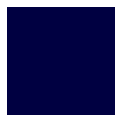

max diff in relevancy tensor(665.5602)
torch.Size([10, 12, 12])


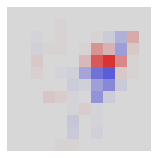

In [128]:
R1 = rel(12)
R101 = rel(112)

for i,l in enumerate([4,3]):
    dat = (R1[l][0] - R101[l][0]) # .abs()

    print("max diff in relevancy", np.abs(dat).max())
    print(dat.shape)
    tut_utils.heatmap(dat.sum(axis=0), 0.5*i+1.5,0.5*i+1.5)

### Explaining the model with LRP

# Here I stopped the implementation, bc I would have to rewrite a lot of the code and I'm more interested in the CNN Mnist.

In [13]:
R = [None]*L + [A[L]*(T[:,None]==np.arange(10))]

def rho(w,l, x=None):
    if x is None: # normal gamma rule
        return w + [None,0.1,0.0,0.0][l] * np.maximum(0,w)

    # neuron wise gamma rule
    gammas = calc_gamma_for_sign_flip(w, x, log=False)
    gammas = gammas.clip(min=0, max=10000)

    print(gammas[:8, :8])

    return w + np.maximum(0,w) * gammas * [None, 0.0, 0.99, 0.0][l]

def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

for l in range(1,L)[::-1]:

    w = rho(W[l],l, A[l])
    b = rho(B[l],l)
    
    z = incr(A[l].dot(w)+b,l)    # step 1
    s = R[l+1] / z               # step 2
    c = s.dot(w.T)               # step 3
    R[l] = A[l]*c                # step 4

# input layer -> zB rule
w  = W[0]
wp = np.maximum(0,w)
wm = np.minimum(0,w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9        # step 1
s = R[1]/z                                        # step 2
c,cp,cm  = s.dot(w.T),s.dot(wp.T),s.dot(wm.T)     # step 3
R[0] = A[0]*c-lb*cp-hb*cm                         # step 4

ValueError: operands could not be broadcast together with shapes (100,10) (1,12,100) 

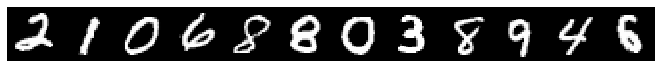

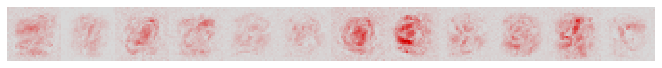

In [12]:
tut_utils.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)
tut_utils.heatmap(R[0].reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)